# Optimizing Solar Farm Site Selection in Quezon Province Using Geospatial Analysis

In [462]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import folium

import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

### Importing Datasets

In [463]:

# Load the GeoJSON data directly into a GeoDataFrame
gdf = gpd.read_file('https://raw.githubusercontent.com/Aizhee/Cognate-Lab-Finals/refs/heads/main/datasets/gadm41_PHL_2.json')

# Filter data for Quezon Province
quezon_gdf = gdf[gdf['NAME_1'] == 'Quezon']

#Clean data
quezon_gdf.drop(index = [1309])

# Load datasets from placeholder CSV files

# Solar Irradiance (example: kWh/m^2/day)
# Source: https://globalsolaratlas.info/map?c=14.02735,121.278489,9
solar_irradiance = pd.read_csv('https://raw.githubusercontent.com/Aizhee/Cognate-Lab-Finals/refs/heads/main/datasets/solar_irradiance.csv')

# Elevation, Population, and Density
additional_info = pd.read_csv('https://raw.githubusercontent.com/Aizhee/Cognate-Lab-Finals/refs/heads/main/datasets/additional_info.csv')

# Proximity to Hazards
hazards = pd.read_csv('https://raw.githubusercontent.com/Aizhee/Cognate-Lab-Finals/refs/heads/main/datasets/hazards.csv')


In [464]:
# Merge datasets with Quezon GeoDataFrame based on region names
data = quezon_gdf[["NAME_2"]].merge(
    solar_irradiance, on="NAME_2", how="left"
).merge(
    additional_info, on="NAME_2", how="left"
).merge(
    hazards, on="NAME_2", how="left"
)

data.tail()

,NAME_2,solar_irradiance,elevation,population,density,active_fault_line,tsunami,lahar
37,Sariaya,4.118,139.0,161868.0,763.0,0.0,0.0,2.0
38,Tagkawayan,3.778,46.0,54003.0,101.0,0.0,0.0,0.0
39,TayabasCity,4.026,228.0,112658.0,488.0,1.0,0.0,2.0
40,Tiaong,4.030,94.0,106265.0,631.0,0.0,0.0,1.0
41,Unisan,3.945,21.0,25448.0,205.0,0.0,0.0,0.0


# Exploratory Data Analysis (EDA)

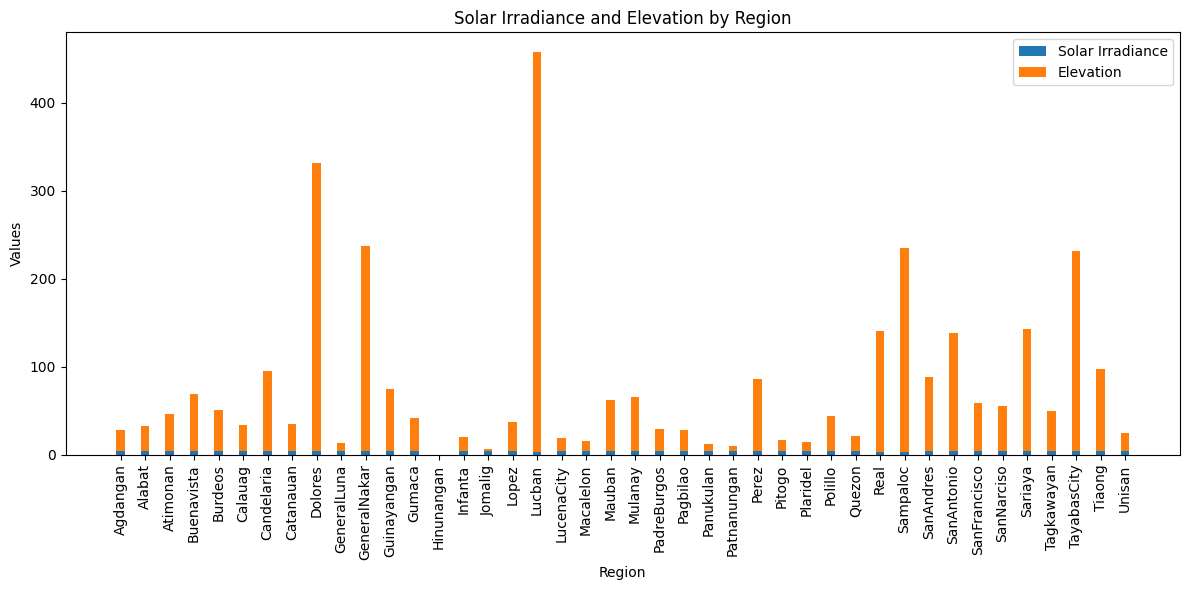

In [465]:
#pyplot bar graph of solar_irradiance and elevation

regions = data['NAME_2']
solar_irradiance_values = data['solar_irradiance']
elevation_values = data['elevation']

# Create the bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of the bars
bar_width = 0.35

# Create bars for solar irradiance and elevation
bar1 = ax.bar(regions, solar_irradiance_values, bar_width, label='Solar Irradiance')
bar2 = ax.bar(regions, elevation_values, bar_width, label='Elevation', bottom=solar_irradiance_values)

# Set labels and title
ax.set_xlabel('Region')
ax.set_ylabel('Values')
ax.set_title('Solar Irradiance and Elevation by Region')

# Add a legend
ax.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the graph
plt.tight_layout()
plt.show()

In [466]:
def normal_curve_value(x, mean, std):
    return stats.norm.pdf(x, loc=mean, scale=std)

# Calculate mean and standard deviation for each hazard column
hazard_columns = ["active_fault_line", "tsunami", "lahar"]
hazard_stats = {}
for column in hazard_columns:
    hazard_stats[column] = {
        "mean": data[column].mean(),
        "std": data[column].std()
    }

# Calculate the normal curve values and sum them for each row
data["hazard_sum"] = 0  # Initialize a new column for the sum

for column in hazard_columns:
    data["hazard_sum"] += data[column].apply(
        lambda x: normal_curve_value(
            x, hazard_stats[column]["mean"], hazard_stats[column]["std"]
        )
    )

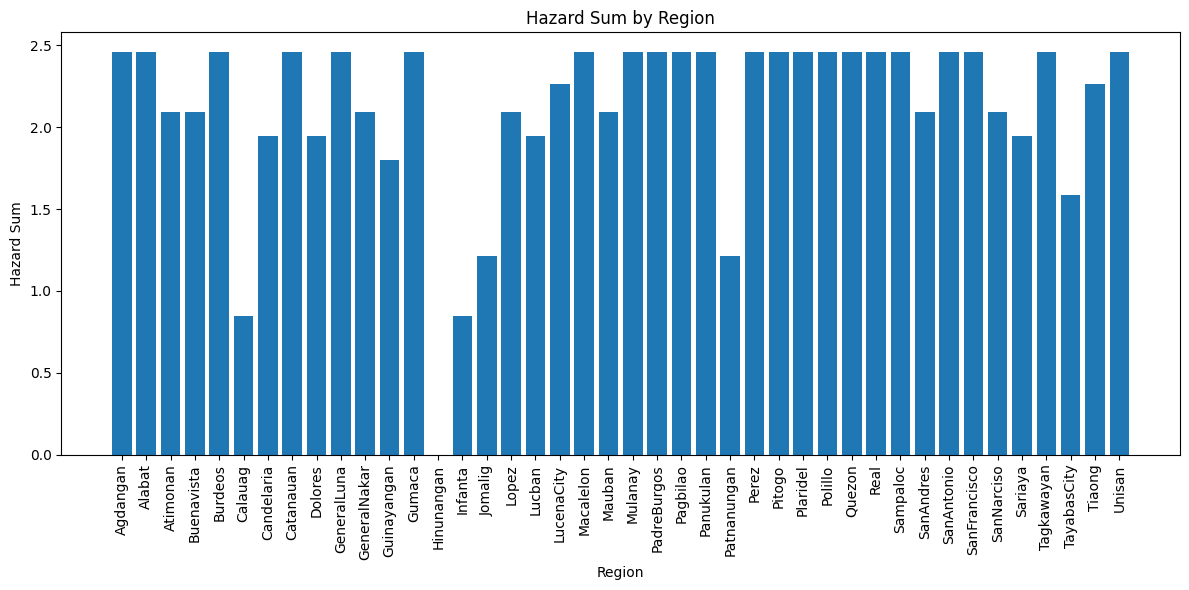

In [467]:
regions = data['NAME_2']  # Get the region names for the x-axis
hazard_sum_values = data['hazard_sum']

# Create the bar graph
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(regions, hazard_sum_values)

# Set labels and title
plt.xlabel('Region')
plt.ylabel('Hazard Sum')
plt.title('Hazard Sum by Region')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Display the graph
plt.tight_layout()  # Adjust layout to prevent overlapping elements
plt.show()

# Feature Engineering

In [468]:
# Constant for kilowathour per person
kilo_watthours_per_person = 790

# Ensure all columns are converted to float
columns_to_float = ["solar_irradiance", "hazard_sum", "density", "population"]
for col in columns_to_float:
    data[col] = data[col].astype(float)

# Perform Min-Max Normalization
for col in columns_to_float:
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())

# Calculate land area
data["land_area"] = quezon_gdf["geometry"].area.to_numpy() * 10
data['elevation'] = (data['elevation'] - data['elevation'].min()) / (data['elevation'].max() - data['elevation'].min())


data.head()

,NAME_2,solar_irradiance,elevation,population,density,active_fault_line,tsunami,lahar,hazard_sum,land_area
0,Agdangan,0.770115,0.048673,0.018790,0.109353,0.0,0.0,0.0,1.000000,0.027312
1,Alabat,0.666667,0.059735,0.030484,0.072518,0.0,0.0,0.0,1.000000,0.048644
2,Atimonan,0.553001,0.088496,0.208632,0.069928,1.0,0.0,0.0,0.774962,0.194717
3,Buenavista,0.794381,0.139381,0.086608,0.048345,1.0,0.0,0.0,0.774962,0.131619
4,Burdeos,0.598978,0.099558,0.062586,0.028201,0.0,0.0,0.0,1.000000,0.194173


In [469]:
# Calculate the composite score
data["composite_score"] = (
    data["solar_irradiance"] * 0.6  # Higher is better
    + data["land_area"] * 0.6       # Higher is better
    - data["elevation"] * 0.0003      # Lower is better
    - data["hazard_sum"] * 0.3      # Lower is better
    - data["density"] * 0.4         # Lower is better
    - (data["population"] / kilo_watthours_per_person) * 0.2  # Lower is better, scaled
)

data.head()

,NAME_2,solar_irradiance,elevation,population,density,active_fault_line,tsunami,lahar,hazard_sum,land_area,composite_score
0,Agdangan,0.770115,0.048673,0.018790,0.109353,0.0,0.0,0.0,1.000000,0.027312,0.134696
1,Alabat,0.666667,0.059735,0.030484,0.072518,0.0,0.0,0.0,1.000000,0.048644,0.100153
2,Atimonan,0.553001,0.088496,0.208632,0.069928,1.0,0.0,0.0,0.774962,0.194717,0.188092
3,Buenavista,0.794381,0.139381,0.086608,0.048345,1.0,0.0,0.0,0.774962,0.131619,0.303709
4,Burdeos,0.598978,0.099558,0.062586,0.028201,0.0,0.0,0.0,1.000000,0.194173,0.164565


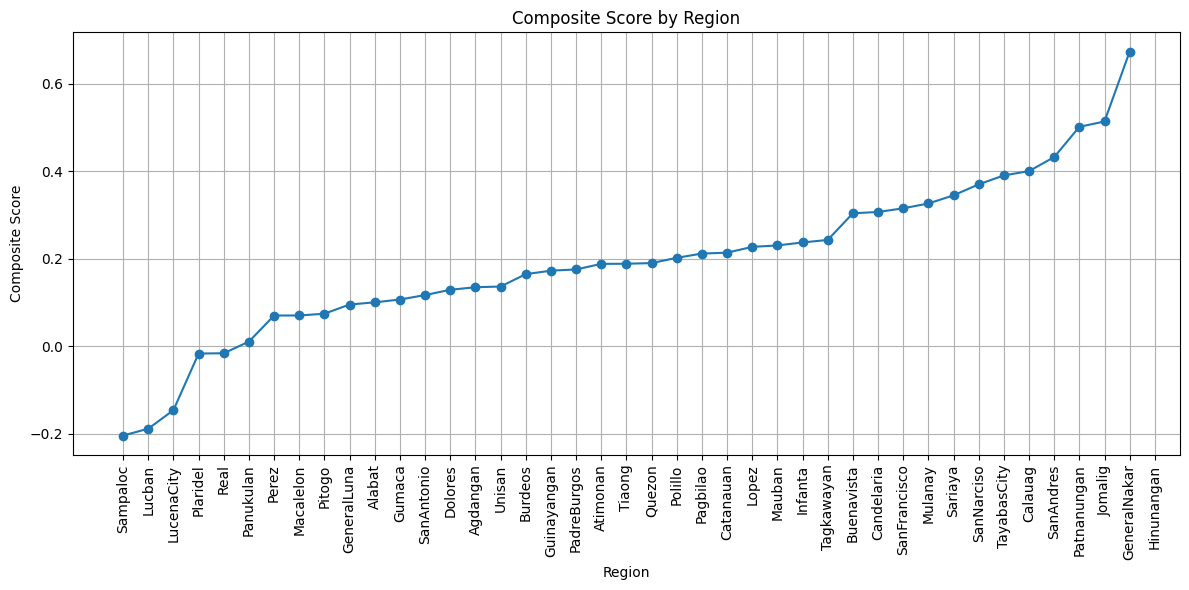

In [475]:
# arrange and visualize data["composite_score"] with a line graph

data_sorted = data.sort_values(by=['composite_score'], ascending=True)

regions = data_sorted['NAME_2']
composite_scores = data_sorted['composite_score']

# Create the line graph
plt.figure(figsize=(12, 6))
plt.plot(regions, composite_scores, marker='o', linestyle='-')

plt.xlabel('Region')
plt.ylabel('Composite Score')
plt.title('Composite Score by Region')
plt.xticks(rotation=90)
plt.grid(True)

plt.tight_layout()
plt.show()

In [470]:
merged_data = pd.merge(quezon_gdf, data, on = 'NAME_2', how = 'inner')

#make sure elevation is a number
merged_data['elevation'] = pd.to_numeric(merged_data['elevation'], errors='coerce')

merged_data.head(5)

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,...,solar_irradiance,elevation,population,density,active_fault_line,tsunami,lahar,hazard_sum,land_area,composite_score
0,PHL.62.1_1,PHL,Philippines,PHL.62_1,Quezon,NA,Agdangan,NA,NA,Bayan|Munisipyo,...,0.770115,0.048673,0.018790,0.109353,0.0,0.0,0.0,1.000000,0.027312,0.134696
1,PHL.62.2_1,PHL,Philippines,PHL.62_1,Quezon,NA,Alabat,NA,NA,Bayan|Munisipyo,...,0.666667,0.059735,0.030484,0.072518,0.0,0.0,0.0,1.000000,0.048644,0.100153
2,PHL.62.3_1,PHL,Philippines,PHL.62_1,Quezon,NA,Atimonan,NA,NA,Bayan|Munisipyo,...,0.553001,0.088496,0.208632,0.069928,1.0,0.0,0.0,0.774962,0.194717,0.188092
3,PHL.62.4_1,PHL,Philippines,PHL.62_1,Quezon,NA,Buenavista,NA,NA,Bayan|Munisipyo,...,0.794381,0.139381,0.086608,0.048345,1.0,0.0,0.0,0.774962,0.131619,0.303709
4,PHL.62.5_1,PHL,Philippines,PHL.62_1,Quezon,NA,Burdeos,NA,NA,Bayan|Munisipyo,...,0.598978,0.099558,0.062586,0.028201,0.0,0.0,0.0,1.000000,0.194173,0.164565


In [471]:
# Remove irrelavent features
#GID_2, GID_0, GID_1, NAME_1, NL_NAME_1, VARNAME_2 NL_NAME_2
merged_data = merged_data.drop(columns=['GID_2', 'GID_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2','HASC_2'])

merged_data.head(5)

,COUNTRY,NAME_2,geometry,solar_irradiance,elevation,population,density,active_fault_line,tsunami,lahar,hazard_sum,land_area,composite_score
0,Philippines,Agdangan,"MULTIPOLYGON (((121.9178 13.8541, 121.9051 13....",0.770115,0.048673,0.018790,0.109353,0.0,0.0,0.0,1.000000,0.027312,0.134696
1,Philippines,Alabat,"MULTIPOLYGON (((122.0669 14.0615, 122.0608 14....",0.666667,0.059735,0.030484,0.072518,0.0,0.0,0.0,1.000000,0.048644,0.100153
2,Philippines,Atimonan,"MULTIPOLYGON (((122.021 13.9193, 122.032 13.91...",0.553001,0.088496,0.208632,0.069928,1.0,0.0,0.0,0.774962,0.194717,0.188092
3,Philippines,Buenavista,"MULTIPOLYGON (((122.49 13.6853, 122.4957 13.67...",0.794381,0.139381,0.086608,0.048345,1.0,0.0,0.0,0.774962,0.131619,0.303709
4,Philippines,Burdeos,"MULTIPOLYGON (((122.0193 14.8055, 122.0232 14....",0.598978,0.099558,0.062586,0.028201,0.0,0.0,0.0,1.000000,0.194173,0.164565


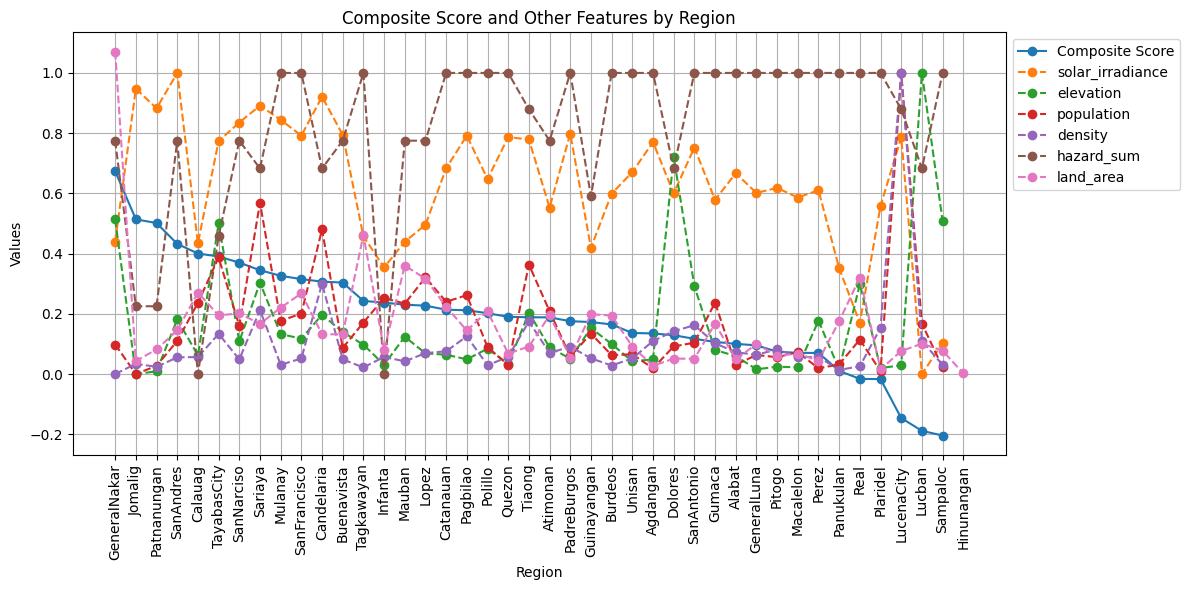

In [478]:
data_sorted = data.sort_values(by=['composite_score'], ascending=False)

regions = data_sorted['NAME_2']
composite_scores = data_sorted['composite_score']

plt.figure(figsize=(12, 6))


plt.plot(regions, composite_scores, marker='o', linestyle='-', label='Composite Score')


features_to_plot = ["solar_irradiance", "elevation", "population", "density", "hazard_sum", "land_area"]
for feature in features_to_plot:
    plt.plot(regions, data_sorted[feature], marker='o', linestyle='--', label=feature)

# 4. Customize the plot
plt.xlabel('Region')
plt.ylabel('Values')
plt.title('Composite Score and Other Features by Region')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 5. Display the graph
plt.tight_layout()
plt.show()

# MAP

In [472]:
# Create a Folium map centered on Quezon Province
m = folium.Map(location=[14.205, 122.003], zoom_start=9)
folium.TileLayer('cartodbpositron', name = 'CartoDB Positron').add_to(m)
# Composite Score Choropleth
choropleth_solar = folium.Choropleth(
    geo_data=merged_data.to_json(),
    name="Composite Score",
    data=data,
    columns=["NAME_2", "composite_score"],
    key_on="feature.properties.NAME_2",
    fill_color="YlGn",  # Green for good, red for bad
    fill_opacity=0.8,
    line_opacity=0.5,
    line_weight=1,
    legend_name="Composite Score (Higher is Better)",
    show=True
).add_to(m)

choropleth_solar.geojson.add_child(
    folium.GeoJsonTooltip(
        fields=["NAME_2", "composite_score", "solar_irradiance", "elevation", "population", "density", "hazard_sum", "land_area"],
        aliases=["Municipality:", "Composite Score:", "Solar Irradiance:", "Elevation:", "Population:", "Density:", "Hazard Sum:", "Land Area:"],
    )
)

# Solar Irradiance Choropleth
choropleth_irradiance = folium.Choropleth(
    geo_data=merged_data.to_json(),
    name="Solar Irradiance",
    data=data,
    columns=["NAME_2", "solar_irradiance"],
    key_on="feature.properties.NAME_2",
    fill_color="YlOrRd",  # Yellow to red for intensity
    fill_opacity=0.8,
    line_opacity=0.5,
    line_weight=1,
    legend_name="Solar Irradiance (kWh/m²/day)",
    show=False  # Initially hide this layer
).add_to(m)

choropleth_irradiance.geojson.add_child(
    folium.GeoJsonTooltip(
        fields=["NAME_2", "solar_irradiance"],
        aliases=["Municipality:", "Solar Irradiance:"],
    )
)

# Elevation Choropleth
choropleth_elevation = folium.Choropleth(
    geo_data=merged_data.to_json(),
    name="Elevation",
    data=data,
    columns=["NAME_2", "elevation"],
    key_on="feature.properties.NAME_2",
    fill_color="Blues",  # Blue shades for elevation
    fill_opacity=0.8,
    line_opacity=0.5,
    line_weight=1,
    legend_name="Elevation (meters)",
    show=False  # Initially hide this layer
).add_to(m)

choropleth_elevation.geojson.add_child(
    folium.GeoJsonTooltip(
        fields=["NAME_2", "elevation"],
        aliases=["Municipality:", "Elevation:"],
    )
)

# Population Choropleth
choropleth_population = folium.Choropleth(
    geo_data=merged_data.to_json(),
    name="Population",
    data=data,
    columns=["NAME_2", "population"],
    key_on="feature.properties.NAME_2",
    fill_color="YlGnBu",  # Green to blue for population
    fill_opacity=0.8,
    line_opacity=0.5,
    line_weight=1,
    legend_name="Population (Total)",
    show=False  # Initially hide this layer
).add_to(m)

choropleth_population.geojson.add_child(
    folium.GeoJsonTooltip(
        fields=["NAME_2", "population"],
        aliases=["Municipality:", "Population:"],
    )
)

# Density Choropleth
choropleth_density = folium.Choropleth(
    geo_data=merged_data.to_json(),
    name="Density",
    data=data,
    columns=["NAME_2", "density"],
    key_on="feature.properties.NAME_2",
    fill_color="Purples",  # Purple shades for density
    fill_opacity=0.8,
    line_opacity=0.5,
    line_weight=1,
    legend_name="Population Density (per km²)",
    show=False  # Initially hide this layer
).add_to(m)

choropleth_density.geojson.add_child(
    folium.GeoJsonTooltip(
        fields=["NAME_2", "density"],
        aliases=["Municipality:", "Density:"],
    )
)

# Hazard Choropleth
choropleth_hazard = folium.Choropleth(
    geo_data=merged_data.to_json(),
    name="Hazard",
    data=data,
    columns=["NAME_2", "hazard_sum"],
    key_on="feature.properties.NAME_2",
    fill_color="Reds",  # Red shades for hazard
    fill_opacity=0.8,
    line_opacity=0.5,
    line_weight=1,
    legend_name="Hazard Sum (Lower is Better)",
    show=False  # Initially hide this layer
).add_to(m)

choropleth_hazard.geojson.add_child(
    folium.GeoJsonTooltip(
        fields=["NAME_2", "hazard_sum"],
        aliases=["Municipality:", "Hazard Sum:"],
    )
)

# Add Layer Control
folium.LayerControl().add_to(m)


Additional Styling and Export

In [473]:
legend_style = '''
<style>
    .legend {
        position: fixed;
        bottom: 10px;
        left: 10px;
        z-index: 1000;
        padding: 10px;
        font-family: Arial, sans-serif;
        font-size: 10px;
        max-width: 500px;
        width: 100%;
    }

    #legend {
        width: 100%;
    }


    // make it responsive
    @media screen and (max-width: 768px) {
        .legend {
            width: 100%;
        }
    }
</style>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_style))


# Save or display the map
m.save("quezon_map_solar_feasability.html")
m